## GANs : Generative Adversarial Networks 


Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. Generative Adversarial Networks. NIPS, 2014. [PDF](https://arxiv.org/pdf/1406.2661v1.pdf)

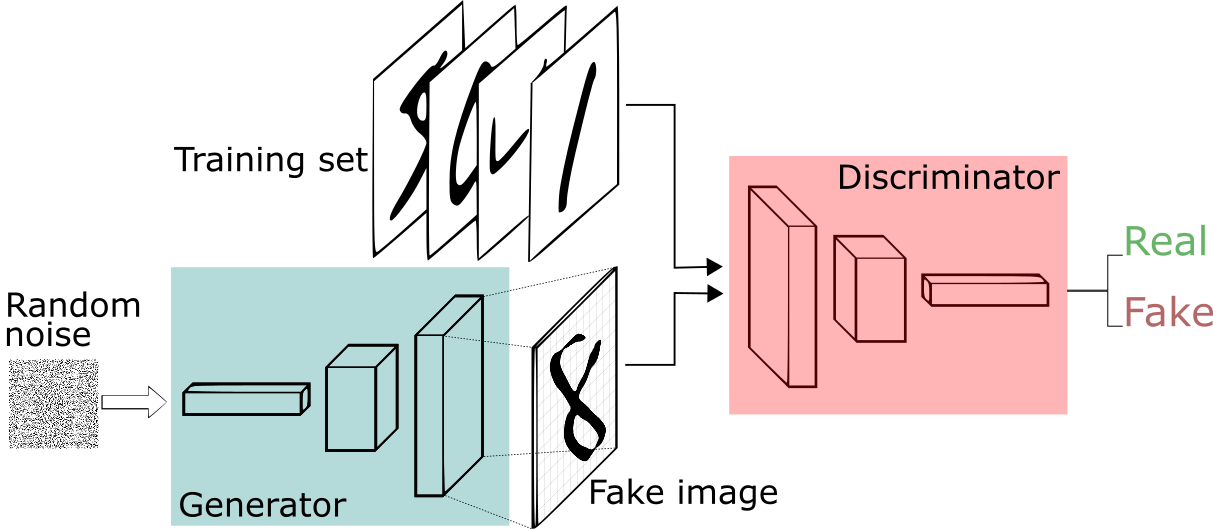

A generative adversarial network (GAN) is a generative model composed of two neural networks: a generator and a discriminator. These two networks are trained in unsupervised way via competition. The generator creates ”realistic” fake images from random noise to fool the discriminator, while the discriminator evaluates the given image for authenticity. 
The loss function that the generator wants to minimize and the discriminator to maximize is as follows: 

min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))] 

Here, G and D are the generator and the discriminator. The first and second term of the loss represent the correct prediction of the discriminator on the real images and on the fake images respectively. 




## DCGAN

• You will implement deep convolutional GAN model on the MNIST dataset with Pytorch. The input image size is 28 x 28. 

• The details of the generator of DCGAN is described below. 

• You will start with batch size of 128, input noise of 100 dimension and Adam optimizer with learning rate of 2e-4. You may vary these hyperparameters for better performance. 

## Architectures


Generator: 

The goal for the generator is to use layers such as convolution, maybe also upsampling layer/transposedConvolution to produce image from the given input noise vector. As this is DCGAN (deep convolutional GAN), we expect you to use convolution in the generator. You will get full credit if you can produce `[batchsize, 1, 28, 28]` vector (image) from the given `[batchsize, 100, 1, 1]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.UpsamplingBilinear2d

• torch.nn.ConvTranspose2d

Non-linear layer: 
 
• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Tanh for the last layer's activation. Can you explain why do we need this in the code comment?


You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

We recommend to use 2 Conv/TransposedConv layers. When you are increasing the feature map size, considering upsample the feature by a factor of 2 each time. If you have width of 7 in one of your feature map, to get output with width of 28, you can do upsampling with factor of 2 and upsampling 2 times. 

Discriminator:

You will get full credit if you can produce an output of `[batchsize, 1]` vector (image) from the given input `[batchsize, 1, 28, 28]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.Linear

Non-linear Layers: 

• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Sigmoid for the last layer's activation. Can you explain why do we need this in the code comment?

Use Leaky ReLu as the activation function between all layers, except after the last layer use Sigmoid.

You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

As an example, you may use 2 convolution layer and one linear layer in the discriminator, you can also use other setup. Note that instead of using pooling to downsampling, you may also use stride=2 in convolution to downsample the feature.

In [3]:
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy import linalg
from scipy.stats import entropy

import torch
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import tqdm


# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([
      transforms.ToTensor(),
      # Normalize the image into [-1,1] range. This is recommended as the tanh
      # function produces output in this range.
      transforms.Normalize((0.5,), (0.5,))
      ])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)



## 1. Model Definition (TODO)

In [5]:
from numpy.core.numeric import outer
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        # input noise is 100D, output is 28x28 image
        self.conv1 = nn.ConvTranspose2d(100, 256, 7, stride=1, padding=0, bias=False)
        self.batch1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)
        self.batch2 = nn.BatchNorm2d(128)
        self.conv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)
        self.batch3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64, 1, 3, stride=1, padding=1, bias=False)
        self.tanh = nn.Tanh()


    def forward(self, input):
        input = self.conv1(input)
        input = self.batch1(input)
        input = self.relu(input)
        input = self.conv2(input)
        input = self.batch2(input)
        input = self.relu(input)
        input = self.conv3(input)
        input = self.batch3(input)
        input = self.relu(input)
        input = self.conv4(input)
        out = self.tanh(input)

        # We use tanh on the last layer to ensure the output (noise) is within a
        # [-1,1] range, as that is our allowed distribution of pixel values
        # after normalizing them from the original [0,1] MNIST pixel values
        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, 9, stride=1, padding=0, bias=False)
        self.batch1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(256, 128, 7, stride=2, padding=1, bias=False)
        self.batch2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, 7, stride=2, padding=1, bias=False)
        self.batch3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 1, 4, stride=1, padding=1, bias=False)
        self.relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = self.conv1(input)
        input = self.batch1(input)
        input = self.relu(input)
        input = self.conv2(input)
        input = self.batch2(input)
        input = self.relu(input)
        input = self.conv3(input)
        input = self.batch3(input)
        input = self.relu(input)
        input = self.conv4(input)
        out = self.sigmoid(input)
        out = out.view(-1,1)

        # We use a sigmoid activation function on the last layer to ensure that
        # the output is in the range of [0, 1], which can be interpreted as
        # the probability that the input image is real (1 = real, 0 = fake)
        return out


# Code that checks size
g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]



d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


## 2. GAN loss (TODO)

In [6]:
def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images (and remember to detach the gradient from the fake images using detach()!)
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''
    real_output = D(real).view(-1)
    loss_real = criterion(real_output, torch.ones_like(real_output))
    fake_images = G(noise)
    fake_output = D(fake_images.detach())
    loss_fake = criterion(fake_output, torch.zeros_like(fake_output))
    loss_D = loss_real + loss_fake

    return loss_D, fake_images

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''

    fake_output = netD.forward(fake)
    loss_G = criterion(fake_output, torch.ones_like(fake_output))
    
    return loss_G

## 3. Training (TODO)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 7, 7]       1,254,400
       BatchNorm2d-2            [-1, 256, 7, 7]             512
              ReLU-3            [-1, 256, 7, 7]               0
   ConvTranspose2d-4          [-1, 128, 14, 14]         524,288
       BatchNorm2d-5          [-1, 128, 14, 14]             256
              ReLU-6          [-1, 128, 14, 14]               0
   ConvTranspose2d-7           [-1, 64, 28, 28]         131,072
       BatchNorm2d-8           [-1, 64, 28, 28]             128
              ReLU-9           [-1, 64, 28, 28]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             576
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 1,911,232
Trainable params: 1,911,232
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

[0/5][0/600]	Loss_D: 1.4193	Loss_G: 1.0859	
[0/5][50/600]	Loss_D: 0.6530	Loss_G: 1.8592	
[0/5][100/600]	Loss_D: 1.1424	Loss_G: 1.1306	
[0/5][150/600]	Loss_D: 0.8355	Loss_G: 1.8334	
[0/5][200/600]	Loss_D: 0.2963	Loss_G: 1.9850	
[0/5][250/600]	Loss_D: 0.2587	Loss_G: 3.2090	
[0/5][300/600]	Loss_D: 2.5319	Loss_G: 2.1917	
[0/5][350/600]	Loss_D: 0.7832	Loss_G: 1.0954	
[0/5][400/600]	Loss_D: 1.0097	Loss_G: 1.3507	
[0/5][450/600]	Loss_D: 0.6365	Loss_G: 1.9709	
[0/5][500/600]	Loss_D: 0.7779	Loss_G: 1.7227	
[0/5][550/600]	Loss_D: 0.6829	Loss_G: 2.2872	
[1/5][0/600]	Loss_D: 0.5300	Loss_G: 2.0747	
[1/5][50/600]	Loss_D: 0.5897	Loss_G: 1.7187	
[1/5][100/600]	Loss_D: 1.0362	Loss_G: 1.3106	
[1/5][150/600]	Loss_D: 1.0185	Loss_G: 1.1620	
[1/5][200/600]	Loss_D: 0.5774	Loss_G: 2.7087	
[1/5][250/600]	Loss_D: 0.8273	Loss_G: 0.7321	
[1/5][300/600]	Loss_D: 1.2002	Loss_G: 0.8079	
[1/5][350/600]	Loss_D: 0.4922	Loss_G: 2.7705	
[1/5][400/600]	Loss_D: 0.6757	Loss_G: 1.3380	
[1/5][450/600]	Loss_D: 1.1584	Loss_G: 3.

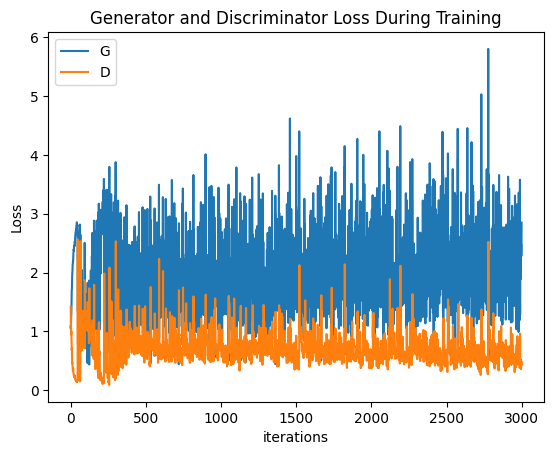

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
# for Adam optimizer, beta1 is momentum, beta2 is for exponential average
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))


img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 5

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        optimizerD.zero_grad()
        loss_D, fake_images = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion, optimizerD)
        loss_D.backward()
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        optimizerG.zero_grad()
        loss_G = loss_generator(netD, netG, fake_images, Valid_label, criterion, optimizerG)
        # update the generator with the updated fake images, need to call optimizerG.step()
        # to update the generator's parameters based on the generator loss.
        loss_G.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))



## 4. Qualitative Visualisations

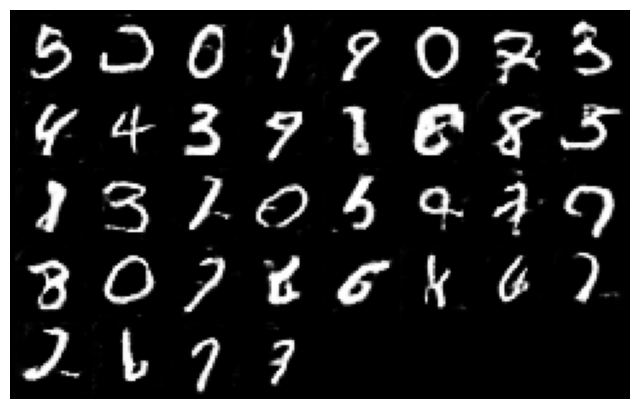

In [10]:
# Test GAN on a random sample and display on 6X6 grid
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())